In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools


# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('C:/Users/Laroybafi.Ramadhano/Documents/05. PowerBI/02. Volume Forecast/volume forecast - input - qris.csv')
print(df.tail())
print(df.dtypes)

     TIME_VALUE     VOLUME
933  2023-08-23  190187638
934  2023-08-24  183983770
935  2023-08-25  226645682
936  2023-08-26  249868918
937  2023-08-27  246406195
TIME_VALUE    object
VOLUME         int64
dtype: object


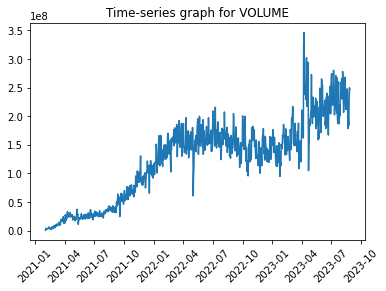

In [3]:
df['TIME_VALUE'] = pd.to_datetime(df['TIME_VALUE'])
df['TIME_VALUE']=df['TIME_VALUE'].dt.date
# df = df[df['TIME_VALUE']>='2021-01-03']
df.set_index('TIME_VALUE', inplace=True)

# df['TIME_VALUE']=df['TIME_VALUE'].dt.date

df = df.asfreq(freq='1D')
df = df.sort_index(ascending = True)
df = df.fillna(value = 0)

f, ax = plt.subplots(1,1)
ax.plot(df['VOLUME'])
ax.set_title('Time-series graph for VOLUME')
ax.tick_params(axis = 'x', rotation = 45)

plt.show()
plt.close()

In [4]:
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 7, center = False).mean()
    rolstd = df[ts].rolling(window = 7, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

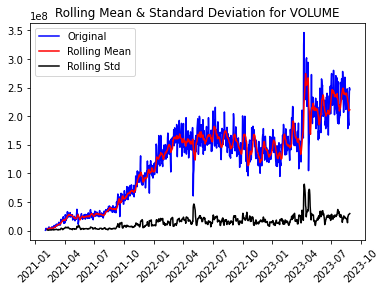

Results of Dickey-Fuller Test:
Test Statistic                  -1.098435
p-value                          0.715696
# Lags Used                     20.000000
Number of Observations Used    917.000000
Critical Value (1%)             -3.437501
Critical Value (5%)             -2.864697
Critical Value (10%)            -2.568451
dtype: float64


In [5]:
test_stationarity(df = df, ts = 'VOLUME')

In [6]:
def plot_transformed_data(df, ts, ts_transform):
    """
    Plot transformed and original time series data
    """
  # Plot time series data
    f, ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transform], color = 'red')

  # Add title
    ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
    ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
    ax.legend([ts, ts_transform])
  
    plt.show()
    plt.close()
  
    return

In [7]:
# CREATE NEW DF
df_example = df.loc[:,:]

# Transformation - log ts
df_example['ts_log'] = df_example.loc[:,('VOLUME')].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example.loc[:,('ts_log')].rolling(window = 7, center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example.loc[:,('VOLUME')].rolling(window = 7, center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
df_example['ts_log_diff'] = df_example.loc[:,('ts_log')].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example.loc[:,('VOLUME')] - df_example.loc[:,('ts_moving_avg')]

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example.loc[:,('ts_log')] - df_example.loc[:,('ts_log_moving_avg')]

In [8]:
df_example_transform = df_example.loc[:,:].dropna().copy()

In [9]:
# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform.loc[:,('ts_log')].ewm(halflife = 7, ignore_na = False, min_periods = 0, adjust = True).mean()

In [10]:
# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform.loc[:,('ts_log')] - df_example_transform.loc[:,('ts_log_ewma')]

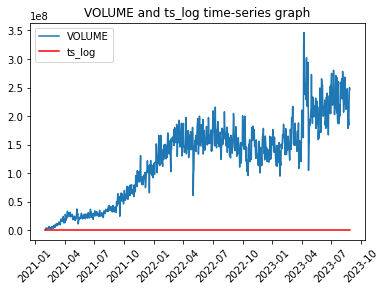

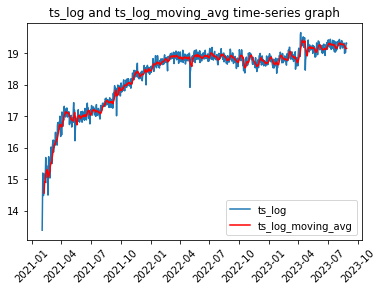

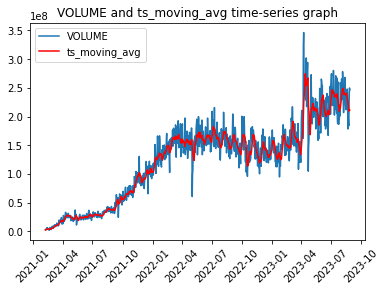

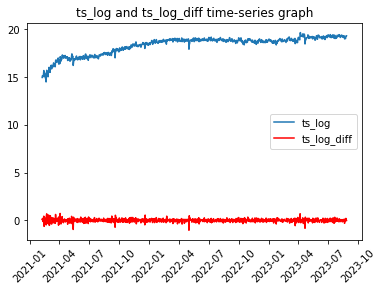

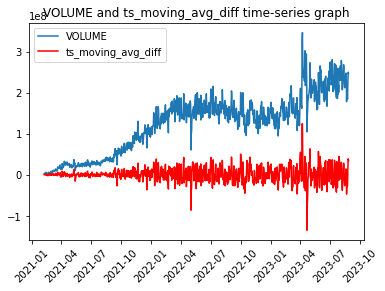

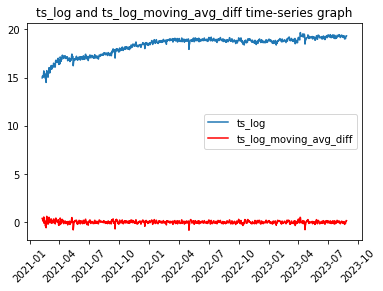

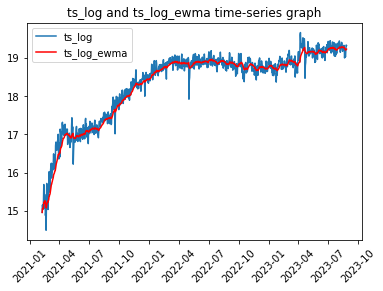

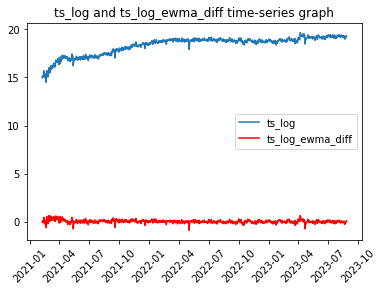

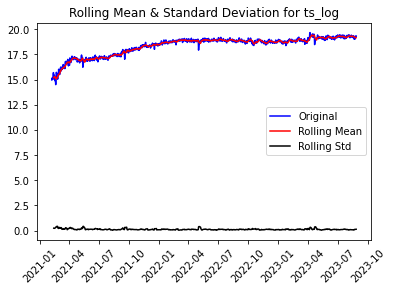

Results of Dickey-Fuller Test:
Test Statistic                  -4.927022
p-value                          0.000031
# Lags Used                     20.000000
Number of Observations Used    911.000000
Critical Value (1%)             -3.437548
Critical Value (5%)             -2.864718
Critical Value (10%)            -2.568462
dtype: float64


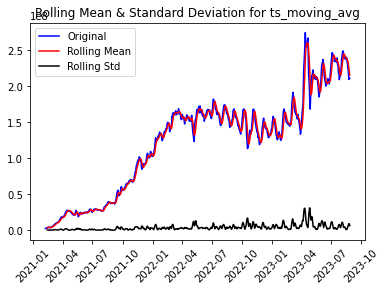

Results of Dickey-Fuller Test:
Test Statistic                  -0.851824
p-value                          0.803424
# Lags Used                     21.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64


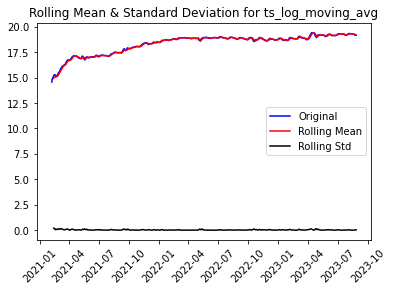

Results of Dickey-Fuller Test:
Test Statistic                -5.926146e+00
p-value                        2.441106e-07
# Lags Used                    2.100000e+01
Number of Observations Used    9.100000e+02
Critical Value (1%)           -3.437556e+00
Critical Value (5%)           -2.864721e+00
Critical Value (10%)          -2.568464e+00
dtype: float64


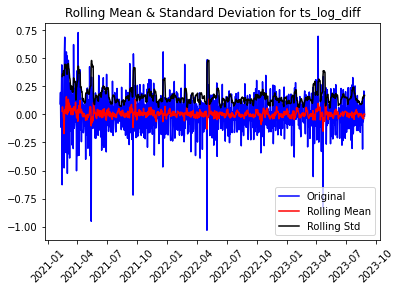

Results of Dickey-Fuller Test:
Test Statistic                -7.424114e+00
p-value                        6.617681e-11
# Lags Used                    2.100000e+01
Number of Observations Used    9.100000e+02
Critical Value (1%)           -3.437556e+00
Critical Value (5%)           -2.864721e+00
Critical Value (10%)          -2.568464e+00
dtype: float64


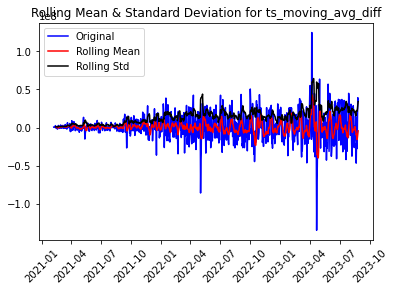

Results of Dickey-Fuller Test:
Test Statistic                -1.061651e+01
p-value                        5.656727e-19
# Lags Used                    2.100000e+01
Number of Observations Used    9.100000e+02
Critical Value (1%)           -3.437556e+00
Critical Value (5%)           -2.864721e+00
Critical Value (10%)          -2.568464e+00
dtype: float64


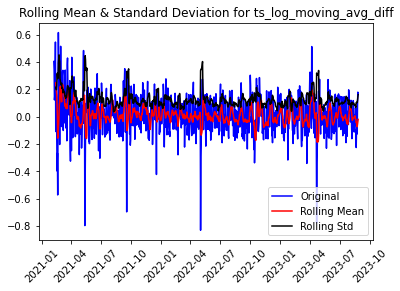

Results of Dickey-Fuller Test:
Test Statistic                -7.038793e+00
p-value                        5.920356e-10
# Lags Used                    2.100000e+01
Number of Observations Used    9.100000e+02
Critical Value (1%)           -3.437556e+00
Critical Value (5%)           -2.864721e+00
Critical Value (10%)          -2.568464e+00
dtype: float64


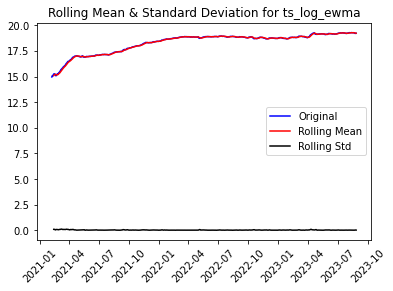

Results of Dickey-Fuller Test:
Test Statistic                  -4.129823
p-value                          0.000864
# Lags Used                     21.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64


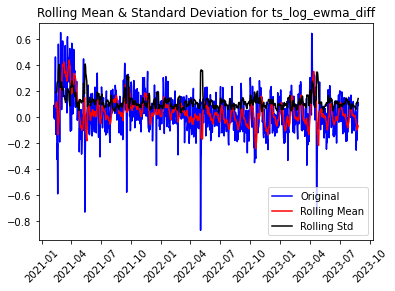

Results of Dickey-Fuller Test:
Test Statistic                  -4.461258
p-value                          0.000231
# Lags Used                     20.000000
Number of Observations Used    911.000000
Critical Value (1%)             -3.437548
Critical Value (5%)             -2.864718
Critical Value (10%)            -2.568462
dtype: float64


In [11]:
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'VOLUME', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'VOLUME', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'VOLUME', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

In [12]:
def plot_decomposition(df, ts, trend, seasonal, residual):
    """
    Plot time series data
    """
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

    ax1.plot(df[ts], label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis = 'x', rotation = 45)

    ax2.plot(df[trend], label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis = 'x', rotation = 45)

    ax3.plot(df[seasonal],label = 'Seasonality')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis = 'x', rotation = 45)

    ax4.plot(df[residual], label = 'Residuals')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()

  # GRAPH
    plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
    plt.show()
    plt.close()

    return

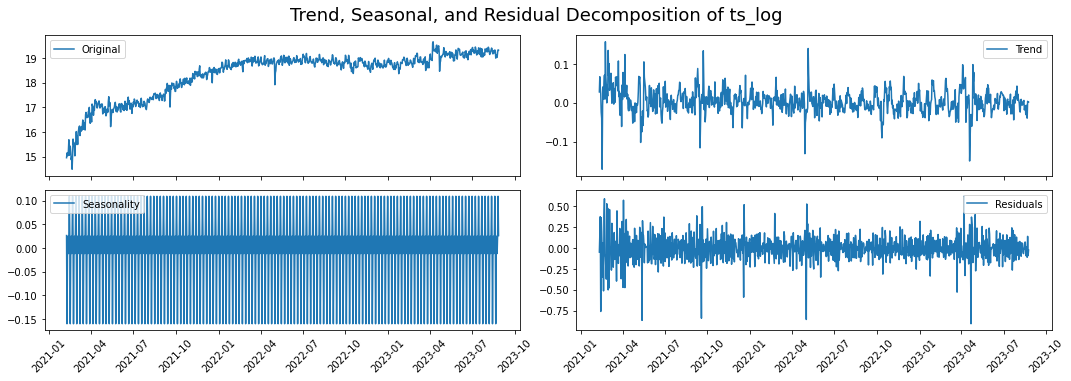

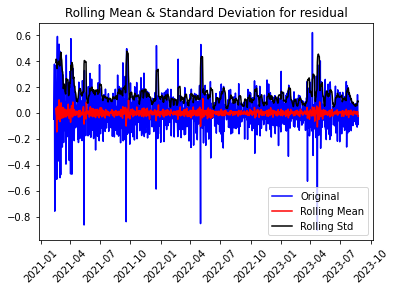

Results of Dickey-Fuller Test:
Test Statistic                -1.475823e+01
p-value                        2.424983e-27
# Lags Used                    2.100000e+01
Number of Observations Used    9.040000e+02
Critical Value (1%)           -3.437604e+00
Critical Value (5%)           -2.864742e+00
Critical Value (10%)          -2.568475e+00
dtype: float64


In [13]:
ts_log_series = pd.Series(df_example_transform['ts_log_diff'])

decomposition = seasonal_decompose(ts_log_series.values, period = 7)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')

In [14]:
df_example_transform_diff = df_example_transform[['ts_log_diff']]
df_example_transform_actual = df_example_transform[['VOLUME']]

y_diff = df_example_transform_diff['ts_log_diff']
y_actual = df_example_transform_actual['VOLUME']

train_diff = y_diff[:'2023-08-19']
test_diff = y_diff['2023-08-20':]
predict_date = len(y_diff) - len(y_diff[:'2023-08-19'])

train_actual = y_actual[:'2023-08-19']
test_actual = y_actual['2023-08-20':]
predict_date_actual = len(y_actual) - len(y_actual[:'2023-08-19'])

In [15]:
def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p,d,q))

    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p,d,q))]

    mini = float('+inf')

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()

                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMAX{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [16]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    sarima_grid_search(y_diff, 7)

The set of parameters with the minimum AIC is: SARIMAX(1, 0, 1)x(0, 1, 1, 7) - AIC:-1010.818333642573


In [17]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y, order, seasonal_order, seasonal_period, pred_date, y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    # pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred = results.get_prediction(start=pred_date, dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - test_diff) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='OBSERVED')
    y_forecasted.plot(ax=ax, label='ONE-STEP AHEAD FORECAST', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    # pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic = results.get_prediction(start=pred_date, dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - test_diff) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='OBSERVED')
    y_forecasted_dynamic.plot(label='DYNAMIC FORECAST', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9601      0.014     67.989      0.000       0.932       0.988
ma.L1         -0.4777      0.031    -15.630      0.000      -0.538      -0.418
ma.S.L7       -0.9260      0.019    -48.879      0.000      -0.963      -0.889
sigma2      4.923e+14        nan        nan        nan         nan         nan


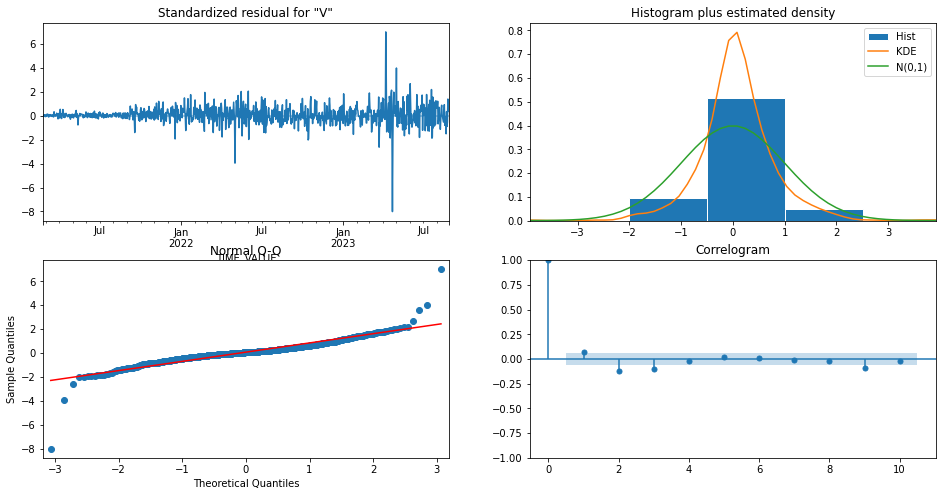

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = False 216949692.58


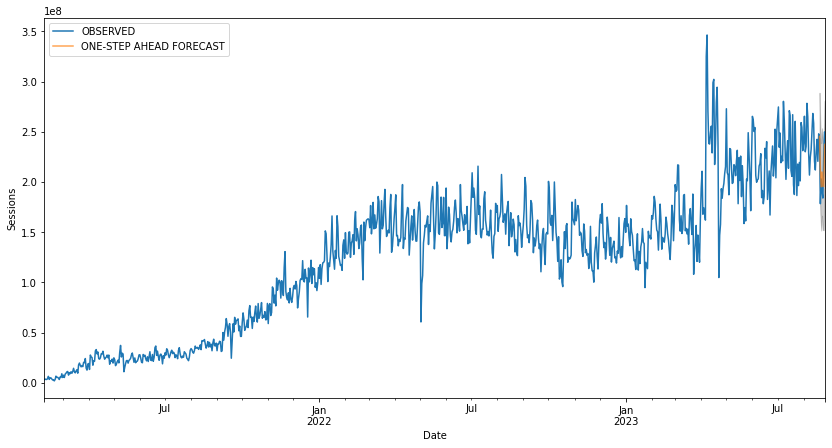

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = True 228246022.8


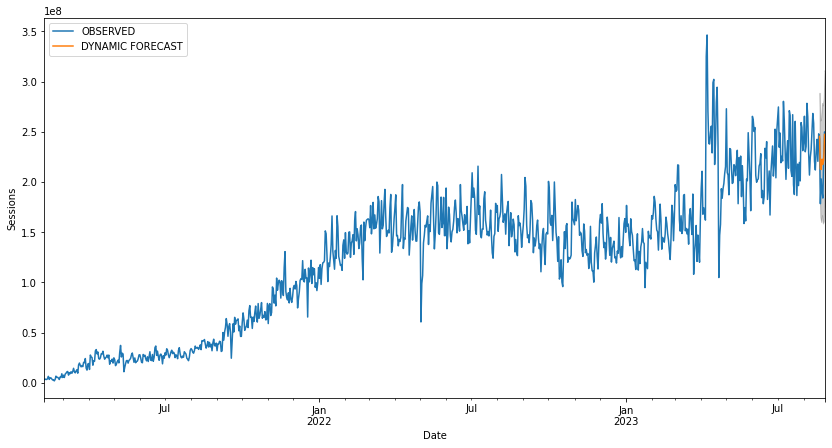

In [21]:
model_sarima = sarima_eva(y_actual, (1,0,1),(0,1,1,7),7,'2023-08-20', test_actual)

In [23]:
def forecast(model, predict_steps, y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='OBSERVED', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='FORECAST')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # PRODUCE THE FORECASTED TABLES 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

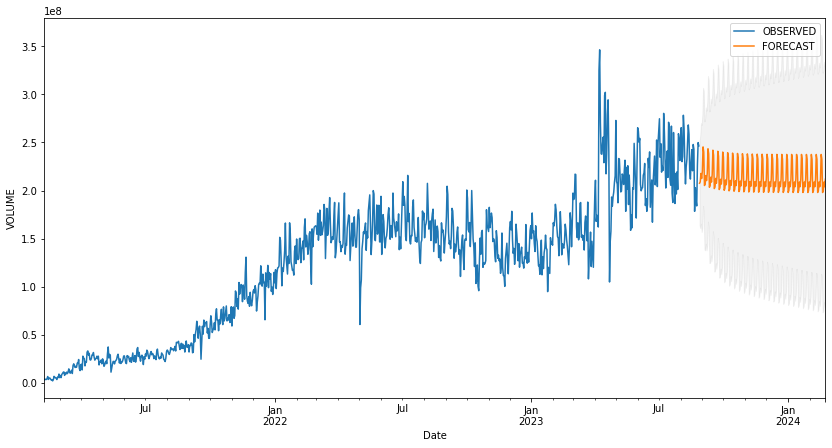

,Date,Predicted_Mean
175,2024-02-19,1.979474e+08
176,2024-02-20,1.997801e+08
177,2024-02-21,2.088610e+08
178,2024-02-22,2.039560e+08
179,2024-02-23,2.118457e+08


In [24]:
final_table = forecast(model_sarima, 180, y_actual)
final_table2 = final_table[['Date','Predicted_Mean']]
final_table2.tail()

In [25]:
# final_table2.to_csv('C:/Users/Laroybafi.Ramadhano/Documents/05. PowerBI/02. Volume Forecast/volume forecast - output - qris.csv')

In [23]:
df_trend = pd.read_csv('C:/Users/Laroybafi.Ramadhano/Documents/trxtrend.csv')
df_trend.tail()

,TIME_VALUE,FLAG,CNT_TRANSACTION,CNT_TRX_ACCT,VOLUME_TRANSACTION
682,2023-01-30,Utility Payment,2671,2208,169786442
683,2023-01-31,QRIS Transaction,1004,827,143141374
684,2023-01-31,Utility Payment,2801,2266,185381446
685,2023-02-01,Utility Payment,2756,2255,193155640
686,2023-02-01,QRIS Transaction,996,825,167589038


In [23]:
df_trend.dtypes

TIME_VALUE            object
FLAG                  object
CNT_TRANSACTION        int64
CNT_TRX_ACCT           int64
VOLUME_TRANSACTION     int64
dtype: object

In [24]:
df_trend['TIME_VALUE'] = pd.to_datetime(df_trend['TIME_VALUE'])
df_trend_sort = df_trend.sort_values(by='TIME_VALUE')
df_trend_sort.set_index('TIME_VALUE', inplace=True)
print(df_trend_sort.head(), df_trend_sort.describe(), sep='\n\n')

                        FLAG  CNT_TRANSACTION  CNT_TRX_ACCT  \
TIME_VALUE                                                    
2022-01-01  QRIS Transaction              805           655   
2022-01-02  QRIS Transaction              985           802   
2022-01-03  QRIS Transaction              853           711   
2022-01-04  QRIS Transaction              914           767   
2022-01-05  QRIS Transaction              930           782   

            VOLUME_TRANSACTION  
TIME_VALUE                      
2022-01-01           104006596  
2022-01-02           117694733  
2022-01-03            98016283  
2022-01-04           113564102  
2022-01-05           119504699  

       CNT_TRANSACTION  CNT_TRX_ACCT  VOLUME_TRANSACTION
count       687.000000    687.000000        6.870000e+02
mean       1571.751092   1275.925764        1.469657e+08
std         816.232444    646.857692        3.926405e+07
min           1.000000      1.000000        2.100000e+04
25%         981.000000    828.000000     

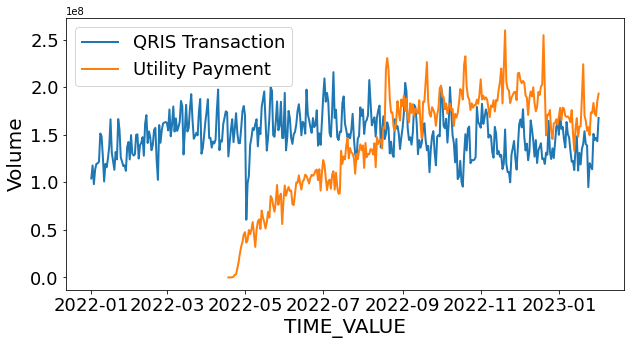

In [33]:
# setting the graph size globally
plt.rcParams['figure.figsize'] = (10, 5)

df_trend_volume = df_trend_sort.pivot_table('VOLUME_TRANSACTION', ['TIME_VALUE'], 'FLAG')


for col in df_trend_volume.columns:
    plt.plot(df_trend_volume[col], linewidth=2, label=col)

plt.xlabel('TIME_VALUE', fontsize=20)
plt.ylabel('Volume', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.show()

In [26]:
df_trend_volume = df_trend.pivot_table('VOLUME_TRANSACTION', ['TIME_VALUE'], 'FLAG')
df_trend_volume

FLAG,QRIS Transaction,Utility Payment
TIME_VALUE,,
2022-01-01,104006596.0,NaN
2022-01-02,117694733.0,NaN
2022-01-03,98016283.0,NaN
2022-01-04,113564102.0,NaN
2022-01-05,119504699.0,NaN
...,...,...
2023-01-28,150921509.0,183358719.0
2023-01-29,144352780.0,172061249.0
2023-01-30,146689407.0,169786442.0


(array([18993., 19052., 19113., 19174., 19236., 19297., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

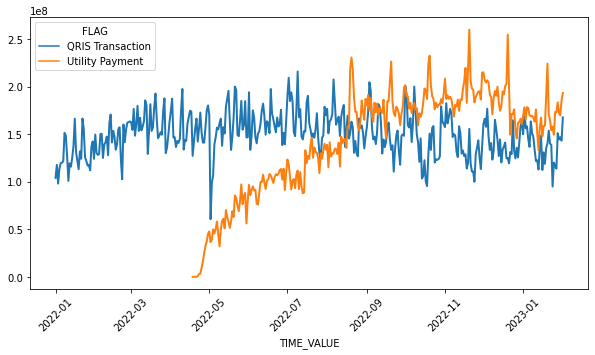

In [34]:
sns.lineplot(data=df_trend_volume, 
                    dashes=False,
                    estimator=None,
                    linewidth=2 )
plt.xticks(rotation=45)

In [30]:
df_trend_trx = df_trend.pivot_table('CNT_TRANSACTION', ['TIME_VALUE'], 'FLAG')
df_trend_trx

FLAG,QRIS Transaction,Utility Payment
TIME_VALUE,,
2022-01-01,805.0,NaN
2022-01-02,985.0,NaN
2022-01-03,853.0,NaN
2022-01-04,914.0,NaN
2022-01-05,930.0,NaN
...,...,...
2023-01-28,1023.0,2707.0
2023-01-29,1061.0,2590.0
2023-01-30,922.0,2671.0


(array([18993., 19052., 19113., 19174., 19236., 19297., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

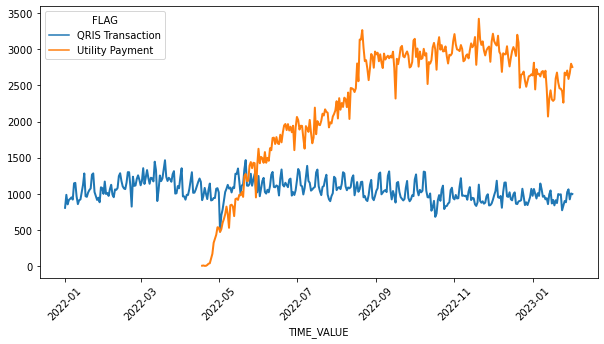

In [35]:
sns.lineplot(data=df_trend_trx, 
                    dashes=False,
                    estimator=None,
                    linewidth=2 )
plt.xticks(rotation=45)